In [13]:
import torch
import numpy as np 
import matplotlib.pyplot as plt
import spatial_maps as sm
import scipy

from tqdm import tqdm
from models import FFGC, RNNGC
from plotting_functions import *
from dataset import DatasetMaker

import umap.umap_ as umap
import plotly.express as px
from sklearn.decomposition import PCA

In [5]:
## Training parameters
train_steps = 50000
timesteps = 10
bs = 64 # batch size

# Model parameters
ng = 256 # no. of recurrent units
alpha = 0.88

In [6]:
# instantiate RNN model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = RNNGC(ng = ng, alpha = alpha)
model = model.load("./best_models/RNNGC.pkl")

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

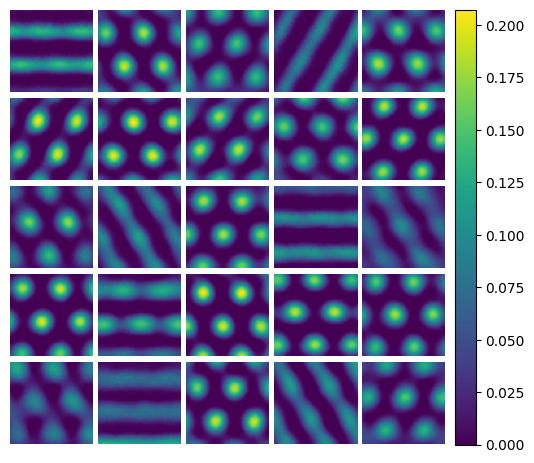

In [65]:
dataset = DatasetMaker()
rt, vt = dataset.generate_data(50000, 10)

rt = rt.to(device)
vt = vt.to(device)

bins = 64

g = model((rt[:,0], vt)).cpu().detach().numpy() # double check that states are alright
g_ratemaps = scipy.stats.binned_statistic_2d(rt[...,0].ravel().cpu().numpy(), rt[...,1].ravel().cpu().numpy(), g.reshape(-1, g.shape[-1]).T, bins = bins)[0]
multiimshow(g_ratemaps[:25], figsize=(5,5));

In [66]:
g_ratemaps.shape

(256, 64, 64)

In [67]:
activity = g_ratemaps.reshape(g_ratemaps.shape[0], -1)
activity.shape

# activity = activity[:128]
activity.shape

(256, 4096)

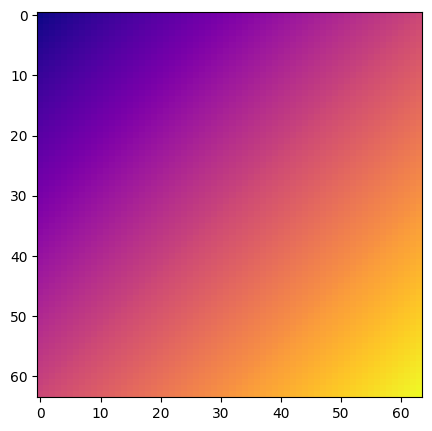

In [68]:
xcol = np.arange(0,int(np.sqrt(activity.shape[-1])))
ycol = np.arange(0,int(np.sqrt(activity.shape[-1])))

xx, yy = np.meshgrid(xcol,ycol)
cols = xx + yy
cols_flat = cols.flatten()

# Plot colormap of cols
fig = plt.figure(figsize=(5,5))
plt.imshow(cols, cmap='plasma')
plt.show()

In [72]:
n_neighbors = 2000
n_components = 3
plot = True

reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=n_components)
reducer.fit(activity.T)
embedding = reducer.transform(activity.T)
print(embedding.shape)
if plot and n_components==2:
    plt.scatter(embedding[:,0],embedding[:,1],s=10)
    plt.gca().set_aspect('equal', 'datalim')
    plt.title('UMAP projection of the activity of the grid cells', fontsize=12)
    plt.show()
elif plot and n_components==3:
    fig = px.scatter_3d(embedding, x=0, y=1, z=2,opacity=0.4,color=cols_flat)
    fig.show()

(4096, 3)


In [73]:
reducer = PCA(n_components=n_components)
reducer.fit(activity.T)
embedding = reducer.transform(activity.T)
print(embedding.shape)
# Explained variance
print(f"Explained variance for PCA with {n_components} components: {100*np.sum(reducer.explained_variance_ratio_):.3f} %")
if plot and n_components==2:
    plt.scatter(embedding[:,0],embedding[:,1],s=10)
    plt.gca().set_aspect('equal', 'datalim')
    plt.title('PCA projection of the activity of the grid cells', fontsize=12)
    plt.show()
elif plot and n_components==3:
    fig = px.scatter_3d(embedding, x=0, y=1, z=2,opacity=0.4,color=cols_flat)
    fig.show()

(4096, 3)
Explained variance for PCA with 3 components: 49.634 %
